<a href="https://colab.research.google.com/github/PosgradoMNA/ML2-Equipo_7-sep-2023/blob/main/TC4033_Activity3a_ID_TEAM_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![Evidence 3](https://i.imgur.com/mu6ZuGT.jpg)

# **Master's in Applied Artificial Intelligence**
## **Course: Advanced Machine Learning Methods**
* ### **Lead Instructor**: José Antonio Cantoral Ceballos

## **Activity A3A: Exploring Word Embeddings with GloVe and Numpy**

* ### **Members - Team 7**

*   --> Eduardo Gabriel Arévalo Aguilar - A01793897
*   --> David Andrés González Medina - A01794025
*   --> Maricel Parra Osorio - A01793932
*   --> Yeison Fernando Villamil Franco - A01793803




## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [47]:
# Import libraries
import os
import shutil
import pickle
import requests
import zipfile
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
plt.style.use('ggplot')

#### Load file

In [48]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = 'http://nlp.stanford.edu/data/glove.6B.zip'
emb_dim = 50

In [49]:
#checking for the presence of the file glove.6B.50d.txt in the current directory.
#if it's not found, it proceeds to download the file from the specified URL and extract its contents.

print('checking for glove.6B.50d.txt in current directory')
imput='glove.6B.50d.txt'
if imput not in os.listdir('./'): #Checks if the file "glove.6B.50d.txt" is not found in the current directory.
    print('glove.6B.50d.txt not found in current directory \ncommencing download from http://nlp.stanford.edu/data/glove.6B.zip')
    r=requests.get(PATH,stream=True)
    block=1024*1024
    toatl_size=int(r.headers['content-length'])
    with open('glove6B.zip','wb') as f:
        for data in tqdm(iterable=r.iter_content(block),total=toatl_size/block,unit='MB'):
            f.write(data)
    zfile=zipfile.PyZipFile('glove6B.zip')
    zfile.extractall(path='glove6B')
    shutil.move('./glove6B/glove.6B.50d.txt','glove.6B.50d.txt')
    shutil.rmtree('glove6B')
else:
    print('requirements satisfied')

checking for glove.6B.50d.txt in current directory
requirements satisfied


In [50]:
#Load the embedings from file
def load_embeddings(path):
  embeddings={} # We create an empty dictionary to store GloVe embeddings.
  with open(imput,'r') as f:
      for i in f.read().split('\n')[:-1]:
        # We read the embeddings file line by line.
        # The last line is usually empty, so we exclude it with [:-1].
          word=i.split()[0].lower() ## We extract the word in lowercase
          embedding=np.asarray(i.split()[1:],dtype='float32') # We extract the word's vector as a NumPy array.
          embeddings[word]= embedding # We store the word and its vector in the glove_vec dictionary.
      return embeddings


**This function creates an embedding matrix from word vectors and a word-to-index mapping dictionary.**

In [51]:
def create_embedding_matrix(embeddings, word_i, emb_dim):

    # Get the total number of words in the vocabulary
    num_words = len(word_i)

    # Create a matrix of zeros with a size of (number of words in the vocabulary, embedding dimension)
    embedding_matrix = np.zeros((num_words, emb_dim))

    # Iterate through each word in the word_i dictionary
    for word, index in word_i.items():

       # Attempt to retrieve the embedding vector corresponding to the word
        embedding = embeddings.get(word)

        # If an embedding vector is found for the word
        if embedding is not None:

            # Assign that embedding vector to the corresponding row in the embedding matrix
            embedding_matrix[index] = embedding

    # Return the created embedding matrix
    return embedding_matrix

**Create a dictionary with word embeddings and related data structures**

In [52]:
def create_emb_dictionary(embeddings, emb_dim):

    # Extract a list of words from the provided embeddings dictionary
    words = list(embeddings.keys())

    # Create a word-to-index dictionary to map words to their corresponding indices
    word_i = {word: index for index, word in enumerate(words)}

    # Create an index-to-word dictionary to map indices back to words
    i_word = {index: word for word, index in word_i.items()}

    # Create an embedding matrix using the provided word embeddings, word-to-index mapping, and embedding dimension
    embedding_matrix = create_embedding_matrix(embeddings,word_i,emb_dim)

    # Return the word-to-index dictionary, index-to-word dictionary, and the embedding matrix
    return word_i, i_word, embedding_matrix

In [53]:
# create dictionary
embedings = load_embeddings(imput)
embeddings_dict = create_emb_dictionary(embedings, emb_dim)

**In the following print it is possible to see the numerical representation of each word that the embedding algorithm allow us show a better way to treat a natural language processing. With that, each word has a semantic representation**

In [54]:
embeddings_dict

({'the': 0,
  ',': 1,
  '.': 2,
  'of': 3,
  'to': 4,
  'and': 5,
  'in': 6,
  'a': 7,
  '"': 8,
  "'s": 9,
  'for': 10,
  '-': 11,
  'that': 12,
  'on': 13,
  'is': 14,
  'was': 15,
  'said': 16,
  'with': 17,
  'he': 18,
  'as': 19,
  'it': 20,
  'by': 21,
  'at': 22,
  '(': 23,
  ')': 24,
  'from': 25,
  'his': 26,
  "''": 27,
  '``': 28,
  'an': 29,
  'be': 30,
  'has': 31,
  'are': 32,
  'have': 33,
  'but': 34,
  'were': 35,
  'not': 36,
  'this': 37,
  'who': 38,
  'they': 39,
  'had': 40,
  'i': 41,
  'which': 42,
  'will': 43,
  'their': 44,
  ':': 45,
  'or': 46,
  'its': 47,
  'one': 48,
  'after': 49,
  'new': 50,
  'been': 51,
  'also': 52,
  'we': 53,
  'would': 54,
  'two': 55,
  'more': 56,
  "'": 57,
  'first': 58,
  'about': 59,
  'up': 60,
  'when': 61,
  'year': 62,
  'there': 63,
  'all': 64,
  '--': 65,
  'out': 66,
  'she': 67,
  'other': 68,
  'people': 69,
  "n't": 70,
  'her': 71,
  'percent': 72,
  'than': 73,
  'over': 74,
  'into': 75,
  'last': 76,
  'some

In [55]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [56]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [57]:
show_n_first_words(imput, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [58]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func=PCA):

    # Parameters:
    # - emb_path: Path to the embeddings file (not used in this function).
    # - words2show: List of words to be visualized.
    # - emb_dim: Dimension of the word embeddings.
    # - embeddings_dict: Dictionary containing word embeddings.
    # - func: Dimensionality reduction technique (either PCA or TSNE).

    # Unpack the data from the embeddings dictionary
    word_to_index, index_to_word, embedding_matrix = embeddings_dict

    # Create a list of indices of the words to be shown
    i_show = [word_to_index[word] for word in words2show]

    # Select only the embeddings of the words to be shown
    selected_embeddings = embedding_matrix[i_show]

    # Apply the dimensionality reduction function
    if func == PCA:
        reducer = PCA(n_components=2)
    elif func == TSNE:
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
    else:
        raise ValueError("The parameter 'func' should be either 'PCA' or 't-SNE'")

    # Perform dimensionality reduction on the selected embeddings
    embeddings_2d = reducer.fit_transform(selected_embeddings)

    # Visualize the results
    plt.figure(figsize=(13, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, c='teal', s=30)

    # Annotate the words on the plot
    for i, word in enumerate(words2show):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

    # Set the title of the plot
    plt.title(f'{func.__name__} Word Embeddings Visualization')
    plt.show()



In [59]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


**Because numerical values can be shown in dimensions that cannot be represented in graphs, it is possible to establish a dimensionality reduction with the objective of observing the position of each word on a Cartesian plane based on its embedding.**

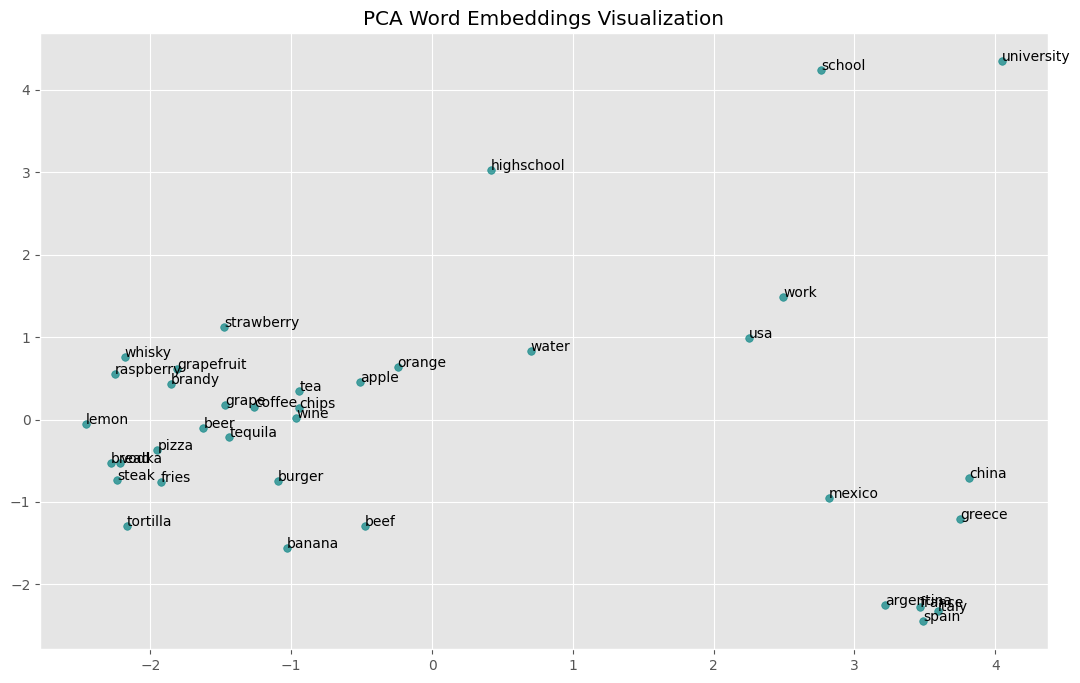

In [60]:
plot_embeddings(imput, words, emb_dim, embeddings_dict, PCA)

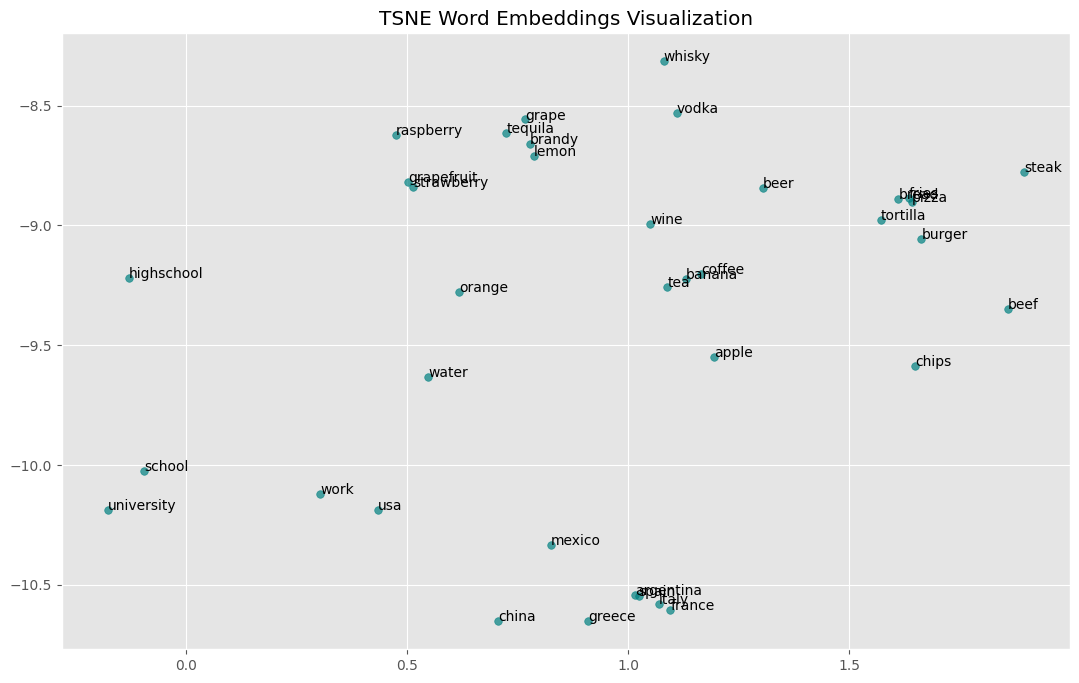

In [61]:
# t-SNE dimensionality reduction for visualization
plot_embeddings(imput, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

**The funtion analogy is used to find words analogous to a given relationship between three words.**

In [63]:
def analogy(word1, word2, word3, embeddings_dict):

    # Parameters:
    # - word1, word2, word3: The three words that establish the relationship.
    # - embeddings_dict: Dictionary of word embeddings.

    # Unpack the data from the embeddings dictionary
    word_i, i_word, embedding_matrix = embeddings_dict

    # Verify if the words exist in the embeddings dictionary
    if word1 not in word_i or word2 not in word_i or word3 not in word_i:
        raise ValueError("One or more of the provided words are not found in the embedding dictionary")

    # Get the vectors of the given words
    vector_word1 = embedding_matrix[ word_i[word1]]
    vector_word2 = embedding_matrix[ word_i[word2]]
    vector_word3 = embedding_matrix[ word_i[word3]]

    # Determine the analogy vector
    analogy_vector = vector_word2 - vector_word1 + vector_word3

    # Determine similarities between the analogy vector and all embedding vectors using (x, y) = x . y / ||x||"
    similarities = {word: np.dot(analogy_vector,  embedding_matrix[word_i[word]]) #get de dot product of each word
                     /  (np.linalg.norm(analogy_vector) #calculate the norm of the vector
                    * np.linalg.norm( embedding_matrix[ word_i[word]])) #calculate the norm of the vector
                     for word in word_i #skip the origin words
                      if word != word1 and word != word2 and word != word3
                   }

    # Identify the word with the highest similarity
    most_similar_word = max(similarities, key=similarities.get)

    return most_similar_word

**This code calculates the word that completes the analogy and prints it in the sentence, providing the result of the word analogy.**

In [67]:
w1='man'
w2='king'
w3='woman'

#This code calculates the word that completes the analogy and prints it in the sentence, providing the result of the word analogy.
analogy_words= analogy(w1,w2,w3, embeddings_dict)
print(f"{w1} is to {w2} as {w3} is to {analogy_words}")

man is to king as woman is to queen


**Find the top n most similar words**

In [72]:
# Find the top n most similar words
def find_most_similar(word, embeddings_dict, top_n=10):

    # Unpack the data from the embeddings dictionary
    word_i, i_word, embedding_matrix = embeddings_dict

    # Verify if the input word exists in the embeddings dictionary
    if word not in word_i:
        raise ValueError("One or more of the provided words are not found in the embedding dictionary")

    # Get the vector representation of the input word
    vector_word = embedding_matrix[word_i[word]]

    # Determine cosine similarities between the input word and all other words in the embeddings
    similarities = {
        other_word: np.dot(vector_word, embedding_matrix[word_i[other_word]]) /
        (np.linalg.norm(vector_word) * np.linalg.norm(embedding_matrix[word_i[other_word]]))
        for other_word in word_i if other_word != word
    }

    # Arrange the words in descending order of similarity
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Select the top n words with the highest similarity
    most_similar_words = [word for word, similarity in sorted_similarities[:top_n]]

    return most_similar_words


In [73]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [75]:
most_similar

['mexican',
 'venezuela',
 'colombia',
 'peru',
 'chile',
 'puerto',
 'rico',
 'cuba',
 'guatemala',
 'panama']

In [74]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> m
2 ---> v
3 ---> c
4 ---> p
5 ---> c
6 ---> p
7 ---> r
8 ---> c
9 ---> g
10 ---> p


In [76]:
most_similar = find_most_similar('pizza', embeddings_dict)

In [77]:
most_similar

['sandwich',
 'sandwiches',
 'snack',
 'bakery',
 'fries',
 'burgers',
 'restaurant',
 'bagel',
 'chicken',
 'bread']

## **CONCLUSIONS:**

1. **Exploring Word Embeddings with GloVe and Numpy:** We have learned how to load and explore pre-trained Word Embeddings using GloVe and Numpy. This function is essential for understanding and leveraging word vector representations.

2. **Visualization with PCA and t-SNE:** We applied PCA and t-SNE to reduce the dimensionality of Word Embeddings and visualize relationships between words in lower-dimensional spaces. These techniques are crucial for gaining visual insights into word semantics.

3. **Word Similarity Function:** We implemented a function that calculates word similarity using dot products and vector norms. This is useful for finding similar words based on their vector representations.

4. **Word Analogy Function:** We implemented a function that solves word analogies using vector operations. This allows us to find words that follow similar relationships as given, such as "man is to king as woman is to ____."

Each of these functions has specific applications in natural language processing, such as semantic search, improving recommendation engines, and generating coherent text. Together, these functions provide us with powerful tools to work with Word Embeddings and harness their potential in various applications.